# Lane finding: Challenge Video

Attempting lane finding pipeline on the challenge video below with light intensity brightness.
Does it still work? Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [1]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from utils import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Save Image frames from Video

In [2]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video = VideoFileClip('test_videos/challenge.mp4') # frame_rate = 25

count = 0
for t_s in np.arange(0, 10.5, 0.5):    
    video.save_frame('challenge_video_frames/{:02d}.jpg'.format(count), t=t_s) # save frame at t=t_s as JPEG
    count += 1

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


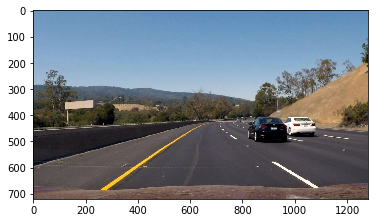

In [3]:
#reading in an image
image = mpimg.imread('challenge_video_frames/00.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

y, x, _ = image.shape

In [10]:
import os
test_image_names = os.listdir("challenge_video_frames/")
test_image_names = sorted(test_image_names)

# remove .dummy file
test_image_names.pop(0)

print(test_image_names)

['00.jpg', '01.jpg', '02.jpg', '03.jpg', '04.jpg', '05.jpg', '06.jpg', '07.jpg', '08.jpg', '09.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg', '18.jpg', '19.jpg', '20.jpg']


### Create two regions for left and right lane 

In [11]:
p1 = (int(0.80 * x), int(0.93 * y))
p2 = (int(0.54 * x), int(0.63 * y))
p3 = (int(0.58 * x), int(0.63 * y))
p4 = (int(0.88 * x), int(0.93 * y))
r_roi = [p1, p2, p3, p4]

p1 = (int(0.16 * x), int(0.93 * y))
p2 = (int(0.45 * x), int(0.63 * y))
p3 = (int(0.50 * x), int(0.63 * y))
p4 = (int(0.30 * x), int(0.93 * y))
l_roi = [p1, p2, p3, p4]

### Use the loop below to debug logic, try concepts and save images

In [12]:
save_intermediate_images = False

for i, t_img_name in enumerate(test_image_names):
    # print(t_img_name)
    base_img = cv2.imread("challenge_video_frames/" + t_img_name)
    
    if save_intermediate_images:
        cv2.imwrite("test_challenge_frames/intermediate_images/{}_00_color{}"
                    .format(t_img_name[:-4], t_img_name[-4:]), base_img)
    
    # draw roi region over color image
    img = np.copy(base_img)
    img = draw_quadrilateral(img, l_roi)
    img = draw_quadrilateral(img, r_roi)
    
    if save_intermediate_images: 
        cv2.imwrite("test_challenge_frames/intermediate_images/{}_01_color_roi{}"
                    .format(t_img_name[:-4], t_img_name[-4:]), img)
    
    # define range of yellow color in HSV
    # (30, 255, 255) actual Yellow HSV value
    lower_yellow = np.array([20, 50, 50])
    upper_yellow = np.array([40, 255, 255])
    yellow_grayscale = grayscale(color_in_range(base_img, lower_yellow, upper_yellow, format="BGR"),
                                 format="HSV")
    
    out_img = grayscale(base_img, format="BGR")
    out_img = weighted_img(out_img, yellow_grayscale, α=1.0, β=1.0, γ=0.0)
    
    if save_intermediate_images:
        cv2.imwrite("test_challenge_frames/intermediate_images/{}_02_weighted_gray{}"
                    .format(t_img_name[:-4], t_img_name[-4:]), yellow_grayscale)
    
    out_img = gaussian_blur(out_img, kernel_size = 9)
    out_img = canny(out_img, low_threshold = 50, high_threshold = 150)
    
    out_img = np.bitwise_or(region_of_interest(out_img, np.int32([l_roi])),
                            region_of_interest(out_img, np.int32([r_roi])))
    
    if save_intermediate_images:
        cv2.imwrite("test_challenge_frames/intermediate_images/{}_03_canny_roi{}"
                    .format(t_img_name[:-4], t_img_name[-4:]), out_img)
    
    out_img = hough_lines(out_img,
                          rho = 1,
                          theta = np.pi/180,
                          threshold = 10,
                          min_line_len = 3,
                          max_line_gap = 1,
                          draw_hough_lines=True,
                          clip=30)
    
    if save_intermediate_images:
        cv2.imwrite("test_challenge_frames/intermediate_images/{}_04_lanes{}"
                .format(t_img_name[:-4], t_img_name[-4:]), out_img)
    
    out_img = weighted_img(out_img, base_img, α=0.8, β=1., γ=0.)
    
    if save_intermediate_images:
        cv2.imwrite("test_challenge_frames/intermediate_images/{}_05_weight{}"
                .format(t_img_name[:-4], t_img_name[-4:]), out_img)
    
    # print("\n")
    # break

Image format is BGR when read via cv2.imread(...), while
Image format is RGB when read via matplotlib and also the frames extracted by moviepy VideoFileClip api
and as I use both APIs i have included image format parameter wherever required 

### process_image(...)
process_image is invoked for every frame in the video 

In [ ]:
img_counter = 0

def process_image(base_img):
    global img_counter
    imgs = []
    try:
        imgs.append(rgb_to_bgr(base_img))
        
        lower_yellow = np.array([20, 50, 50])
        upper_yellow = np.array([40, 255, 255])
        yellow_grayscale = grayscale(color_in_range(base_img, lower_yellow, upper_yellow, format="RGB"),
                                     format="HSV")
        imgs.append(yellow_grayscale)
        
        out_img = grayscale(base_img, format="RGB")
        out_img = weighted_img(out_img, yellow_grayscale, α=1.0, β=1.0, γ=0.0)
        imgs.append(out_img)

        out_img = gaussian_blur(out_img, kernel_size = 9)
        out_img = canny(out_img, low_threshold = 50, high_threshold = 150)
        out_img = np.bitwise_or(region_of_interest(out_img, np.int32([l_roi])),
                                region_of_interest(out_img, np.int32([r_roi])))
        imgs.append(out_img)

        out_img = hough_lines(out_img,
                              rho = 1,
                              theta = np.pi/180,
                              threshold = 10,
                              min_line_len = 3,
                              max_line_gap = 1,
                              draw_hough_lines=False,
                              clip=5)
        imgs.append(out_img)
        
        out_img = weighted_img(out_img, base_img, α=0.8, β=1.0, γ=0.0)
        imgs.append(out_img)     
        return out_img
    
    except Exception:
        for i, img in enumerate(imgs):
            cv2.imwrite("test_challenge_frames/error/{}_{}.jpg".format(img_counter, i), img)
        img_counter += 1
        raise Exception("process_image(...)")
        

To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
To do so add .subclip(start_second,end_second) to the end of the line below
Where start_second and end_second are integer values representing the start and end of the subclip
You may also uncomment the following line for a subclip of the first 5 seconds

clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'

In [ ]:
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))